In [1]:
using ProgressMeter, Distributions, DelimitedFiles, Random, LinearAlgebra, LaTeXStrings, Plots


In [2]:
Random.seed!(1);

In [3]:
mutable struct parameter
    n::Int
    q::Int
    avg::Vector{Vector{Float64}}
end;

In [4]:
# initializes correct size for type parameter
function parameter(n::Int, q::Int)
    parameter(n, q, [zeros(Float64, q * q) for _ in 1:(n * n)])
end;

In [5]:
# cartesian to linear indices conversion
function cart2lin(t::Tuple{Int, Int}, dims::Int)
    x, y = t[2], t[1]
    @assert 1 ≤ x ≤ dims && 1 ≤ y ≤ dims
    return y + dims * (x-1)
end;

In [6]:
cart2lin(i::Int, j::Int, dims::Int) = cart2lin((i, j), dims);

In [7]:
# updates the delta structure when the condition is verified
function parameter_update!(δ::parameter, i::Int, j::Int, a::Int, b::Int)
    n = δ.n
    q = δ.q
    δ.avg[cart2lin((i,j), n)][cart2lin((a,b), q)] += 1
    nothing
end;

In [8]:
function compute_stat!(δ::parameter, data::Matrix{Int64}, q::Int)
	count = size(data, 1)
	n = size(data, 2)
	#δ = parameter(n, q)

	for i in 1:n, j in 1:n, a in 1:q, b in 1:q
		δ.avg[cart2lin((i,j), n)][cart2lin((a,b), q)] = dot((data[:, i] .== a), (data[:, j] .== b))
		#[parameter_update!(δ, i, j, a, b) for s in 1:count if (data[s, i] == a) && (data[s, j] == b)]
	end
	δ.avg /= count
	#return δ
	nothing
end;

In [9]:
function maxabs_parameter(δ1::parameter, δ2::parameter)
	m = δ1.avg .- δ2.avg
	max = -1
	for r in m
		if maximum(abs.(r)) > max
			max = maximum(abs.(r))
		end
	end
	return max
end;

maxabs_parameter(δ, n, q) = maxabs_parameter(δ, parameter(n, q))

#=
function maxabs_matmat(m::Matrix{Matrix{Float64}})
	max = -1
	for r in 1:size(m, 1), c in 1:size(m, 2)
		if maximum(abs.(m[r, c])) > max
			max = maximum(abs.(m[r, c]))
		end
	end

	return max
end;
=#

maxabs_parameter (generic function with 2 methods)

In [10]:
function metropolis_hastings_step(x::Vector{Int64}, J_struct::parameter)
	n = length(x)
    J = J_struct.avg
	n = J_struct.n
	q = J_struct.q
    
	# 1. draw uniformly an index and a new configuration
	k = rand(1:n)
	z = rand(1:q)
	
	# 2. compute the acceptance ratio
	a = 0
	xk_new = mod1(x[k] + z, q)
	#=
	for i in 1:n
		if i != k
			a += J[cart2lin(i, k, n)][cart2lin(x[i], xk_new, q)] - J[cart2lin(i, k, n)][cart2lin(x[i], x[k], q)]
		end
	end
	a *= 2
	a += J[cart2lin(k, k, n)][cart2lin(xk_new, xk_new, q)] - J[cart2lin(k, k, n)][cart2lin(x[k], x[k], q)]
	=#
	a = 2*sum([J[cart2lin(i, k, n)][cart2lin(x[i], xk_new, q)] - J[cart2lin(i, k, n)][cart2lin(x[i], x[k], q)] for i in 1:n])
	a -= J[cart2lin(k, k, n)][cart2lin(xk_new, xk_new, q)] - J[cart2lin(k, k, n)][cart2lin(x[k], x[k], q)]
	a = exp(a)
	a = min(1, a)

	# 3/4. decide whether to accept or not the new configuration
	if rand() < a
		x[k] = xk_new
	end
	
	return x
end;

In [11]:
function boltzmann_ml(δ_data::parameter, J::parameter, 
    t_burnin::Int64, t_tot::Int64, t_wait::Int64, t_max::Int64;
    λ::Float64 = 0.1, ε_max::Float64 = 1e-2, verbose::Bool=true)

n = δ_data.n
q = δ_data.q

x = sample(collect(1:q), n, replace = true)
x_model = zeros(Int64, t_tot, n)
δ_model = parameter(n, q)

t = 0
ε = 1
ProgressMeter.ijulia_behavior(:clear)
p = ProgressUnknown("learning...", spinner = true)

while t <= t_max && ε > ε_max
    t += 1
    fill!(x_model, 0)
    x = sample(collect(1:q), n, replace = true)

    for s in 1:t_burnin
        x = metropolis_hastings_step(x, J)
    end

    for s in 1:t_tot
        for r in 1:t_wait
            x = metropolis_hastings_step(x, J)
        end
        x_model[s, :] = x
    end

    compute_stat!(δ_model, x_model, q)

    J.avg += λ .* (δ_data.avg - δ_model.avg)

    ε = maxabs_parameter(δ_data, δ_model)

    if mod(t, t_max ÷ 10) == 0 && verbose
        ProgressMeter.next!(p; showvalues = [(:t, t), (:ε, ε)], spinner = "⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏")
    end

end

ProgressMeter.finish!(p)

return δ_model, J, x_model, t, ε

end;

In [12]:
# parameters
n = 5
q = 4

# the estimation is also acceptable by imposing
# t_burnin = 250
# t_tot = 250
# t_wait = 100
# t_max = 500

t_burnin = 500
t_tot = 500
t_wait = 100
t_max = 500;

In [13]:
# δ_data
x_data = readdlm("data.dat", Int)
δ_data = parameter(n, q)
compute_stat!(δ_data, x_data, q);

In [14]:
# boltzmann ml scheme
J = parameter(n, q)
δ_model, J, x_model, t, ε = boltzmann_ml(δ_data, J, t_burnin, t_tot, t_wait, t_max);

⠋ learning... 	 Time: 0:00:06
  t:  100
  ε:  0.0395

⠙ learning... 	 Time: 0:00:09
  t:  150
  ε:  0.0315

⠹ learning... 	 Time: 0:00:12
  t:  200
  ε:  0.04049999999999998

⠸ learning... 	 Time: 0:00:15
  t:  250
  ε:  0.04799999999999999

⠼ learning... 	 Time: 0:00:18
  t:  300
  ε:  0.03899999999999998

⠴ learning... 	 Time: 0:00:21
  t:  350
  ε:  0.046499999999999986

⠦ learning... 	 Time: 0:00:24
  t:  400
  ε:  0.04050000000000001

⠧ learning... 	 Time: 0:00:27
  t:  450
  ε:  0.04049999999999998

⠇ learning... 	 Time: 0:00:30
  t:  500
  ε:  0.028499999999999998

✓ learning... 	 Time: 0:00:30


In [15]:
#frobenius norm function

p2(x) = x^2

function frobenius_norm(m::Vector{Float64})
	f = sum(p2, m)
	f = sqrt(f)
end;

frobenius_norm(m::Matrix{Float64}) = frobenius_norm(vec(m));

In [16]:
# computation of f_{i, j} for all i, j
f = zeros(n, n)

for i in 1:n, j in 1:n
	f[i, j] = frobenius_norm(J.avg[cart2lin((i,j), n)])
end

display(f)

neighbors = [Int64[], Int64[], Int64[], Int64[], Int64[]]

for i in 1:n, j in 1:n
	if (f[i, j] > 0.2)
		append!(neighbors[i], [j])
	end
end

neighbors = mapreduce(permutedims, vcat, neighbors)
display(neighbors)

5×5 Matrix{Float64}:
 0.0344698  0.732233   0.834471   0.163637   0.118867
 0.732233   0.0275343  0.135054   0.798079   0.110889
 0.834471   0.135054   0.0331039  0.106782   0.886098
 0.163637   0.798079   0.106782   0.0524768  0.90571
 0.118867   0.110889   0.886098   0.90571    0.0242954

5×2 Matrix{Int64}:
 2  3
 1  4
 1  5
 2  5
 3  4

In [17]:
function boltzmann_ml_bayes(δ_data::parameter, J::parameter,
    count::Int64, λ::Int64, t_burnin::Int64, t_tot::Int64, t_wait::Int64, t_max::Int64;
    μ::Float64 = 0.1, ε_max::Float64 = 1e-2, verbose::Bool=true)

n = δ_data.n
q = δ_data.q

bayes_term = parameter(n, q)

for i in 1:size(J.avg, 1), a in 1:size(J.avg, 2)
    bayes_term.avg[i][a] = 1 / (count + 1) * λ * sign(J[i][a])
end

x = sample(collect(1:q), n, replace = true)
x_model = zeros(Int64, t_tot, n)
δ_model = parameter(n, q)

t = 0
ε = 1
ProgressMeter.ijulia_behavior(:clear)
p = ProgressUnknown("learning...", spinner = true)

while t <= t_max && ε > ε_max
    t += 1
    fill!(x_model, 0)
    x = sample(collect(1:q), n, replace = true)

    for s in 1:t_burnin
        x = metropolis_hastings_step(x, J)
    end

    for s in 1:t_tot
        for r in 1:t_wait
            x = metropolis_hastings_step(x, J)
        end
        x_model[s, :] = x
    end

    δ_model = compute_stat!(x_model, q)

    direction_bayes = (count / (count + 1) * δ_data.avg - δ_model.avg - bayes_term.avg)
    J.avg += μ .* direction_bayes

    ε = maxabs_parameter(direction_bayes, n, q)

    if mod(t, t_max ÷ 10) == 0 && verbose
        ProgressMeter.next!(p; showvalues = [(:t, t), (:ε, ε)], spinner = "⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏")
    end
end

ProgressMeter.finish!(p)

return δ_model, J, x_model, t, ε
end;

In [18]:
# boltzmann ml scheme
count = size(x_data, 1)
λ = 0.1
J_bayes = parameter(n, q)
δ_model_bayes, J_bayes, t_bayes, ε_bayes = boltzmann_ml(δ_data, J_bayes, t_burnin, t_tot, t_wait, t_max);

⠋ learning... 	 Time: 0:00:05
  t:  100
  ε:  0.035

⠙ learning... 	 Time: 0:00:08
  t:  150
  ε:  0.039000000000000035

⠹ learning... 	 Time: 0:00:11
  t:  200
  ε:  0.027499999999999997

⠸ learning... 	 Time: 0:00:14
  t:  250
  ε:  0.057499999999999996

⠼ learning... 	 Time: 0:00:17
  t:  300
  ε:  0.03200000000000003

⠴ learning... 	 Time: 0:00:20
  t:  350
  ε:  0.047000000000000014

⠦ learning... 	 Time: 0:00:22
  t:  400
  ε:  0.03350000000000003

⠧ learning... 	 Time: 0:00:25
  t:  450
  ε:  0.04049999999999998

⠇ learning... 	 Time: 0:00:28
  t:  500
  ε:  0.0665

✓ learning... 	 Time: 0:00:28


In [19]:
# replication of point 2 with J_bayes
f_bayes = zeros(n, n)
for i in 1:n, j in 1:n
	f_bayes[i, j] = frobenius_norm(J_bayes.avg[cart2lin((i,j), n)])
end
display(f_bayes)

neighbors_bayes = [Int64[], Int64[], Int64[], Int64[], Int64[]]
for i in 1:n, j in 1:n
	if (f_bayes[i, j] > 0.2)
		append!(neighbors_bayes[i], [j])
	end
end
neighbors_bayes = mapreduce(permutedims, vcat, neighbors_bayes)
display(neighbors_bayes)

5×5 Matrix{Float64}:
 0.0222092  0.729852   0.830341   0.16369    0.124893
 0.729852   0.02969    0.127029   0.799912   0.0930959
 0.830341   0.127029   0.0331687  0.112486   0.883507
 0.16369    0.799912   0.112486   0.0532691  0.915267
 0.124893   0.0930959  0.883507   0.915267   0.035393

5×2 Matrix{Int64}:
 2  3
 1  4
 1  5
 2  5
 3  4

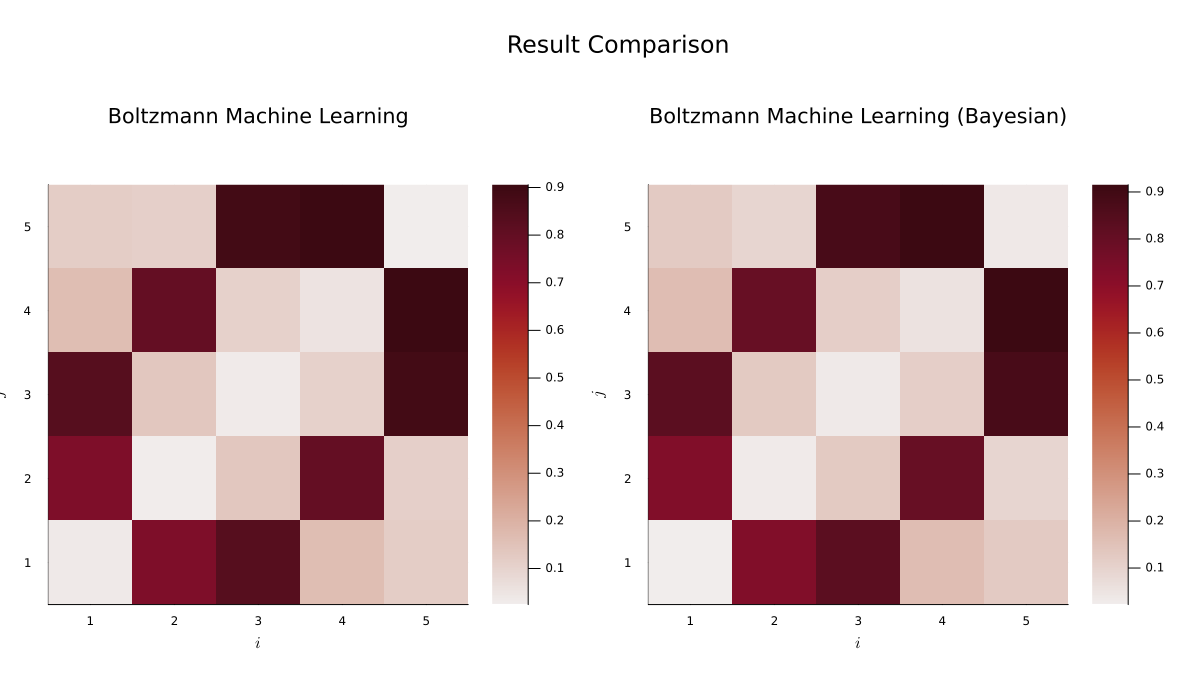

In [20]:
#title = plot(title = "Plot title", grid = false, showaxis = false, margin = -20Plots.px)
plot1 = heatmap(f, xlabel = L"i", ylabel = L"j", title = "Boltzmann Machine Learning", aspect_ratio = 1, xlim = (0.5, 5.5), c = :amp)
plot2 = heatmap(f_bayes, xlabel = L"i", ylabel = L"j", title = "Boltzmann Machine Learning (Bayesian)", aspect_ratio = 1, xlim = (0.5, 5.5), c = :amp)
plot(plot1, plot2, layout = @layout([B C]), legend = false, plot_title= "\nResult Comparison", plot_titlevspan=0.15, size = (1200, 700))

In [21]:
function sample_ind(p, n)
    sum(p) ≈ 1 || error("non normalized weigths")
    cumvec = vcat(0.0,cumsum(p))
    return [searchsortedfirst(cumvec, rand()) - 1 for i in 1:n]
end

sample_ind (generic function with 1 method)

In [22]:
using CairoMakie
using GLMakie

In [23]:
groundtruth = readdlm("groundtruth.dat", Int)
display(groundtruth)
gt = zeros(n, n)
for i in 1:size(groundtruth, 1), j in 1:size(groundtruth, 2)
    gt[i, groundtruth[i, j]] = 1.0
end
display(gt)

5×2 Matrix{Int64}:
 2  3
 1  4
 1  5
 2  5
 3  4

5×5 Matrix{Float64}:
 0.0  1.0  1.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  1.0
 0.0  0.0  1.0  1.0  0.0

In [24]:
M = size(x_data, 1)
#f = [zeros(n, n) for i in 1:M/100]
f_m = zeros(n, n)
ε_m = []

for m in 100:100:M
    
    #p = 1/M * ones(Float64, M)
    x_data_m = x_data[sample(collect(1:M), m, replace = false), :]
    δ_data_m = parameter(n, q)
    J_m = parameter(n, q)
    compute_stat!(δ_data_m, x_data_m, q)
    δ_model_m, J_m, x_model_m, t, ε = boltzmann_ml(δ_data, J_m, t_burnin, t_tot, t_wait, t_max; verbose = false)

    for i in 1:n, j in 1:n
        f_m[i, j] = frobenius_norm(J_m.avg[cart2lin((i,j), n)])
    end

    #push!(ε_m, maximum(abs, f_m .- f))
    push!(ε_m, frobenius_norm(f_m .- f))
end


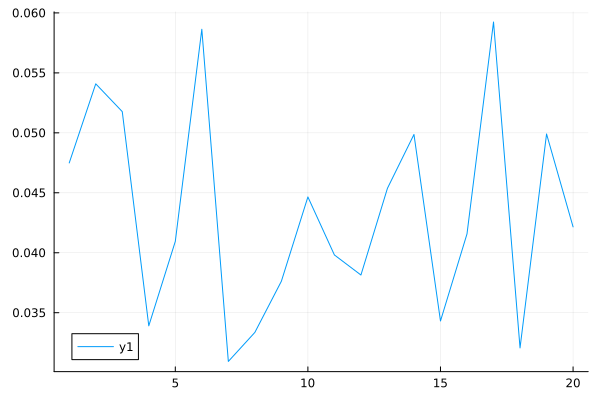

In [25]:
plot(ε_m)

In [26]:
#=numpar = Observable(1)

framerate = 1
timestamps = range(1, round(Int64, M/100), step=1)

#ft = @lift(f[$numpar])
x = LinRange(1, 1, n)
y = LinRange(1, 1, n)
fig, ax, hm = heatmap(x, y, f[1])
#fig, ax, hm = heatmap(ft, xlabel = L"i", ylabel = L"j", aspect_ratio = 1, xlim = (0.5, 5.5), c = :amp, @lift(title = "m = $(100*$numpar)"))


fps = 10
nframes = round(Int64, M/100)


record(fig, "heatmap_animation.mp4", timestamps; 
    framerate = framerate) do m
    hm[3] = f[m]
end
=#


Define the autocorrelation function (for a stationary process) as follows 
\begin{align}
\gamma(r) = \frac{\mathbb{E}[(x^{(t)}-\mu)(x^{(t+r)}-\mu)]}{\sigma^2}
\end{align}

A monte Carlo estimator for it is 

\begin{align}
\hat{\gamma}(r) = \frac{\frac{1}{n-r}\sum_{i=1}^{n-r}(x^{(i)}-\hat{\mu}_{n})(x^{(i+r)}-\hat{\mu}_n)}{\frac{1}{n} \sum_{i=1}^{n} (x^{(i)} - \hat{\mu}_n )^2}.
\end{align}

In [27]:
function autocorrelation(chain, t_waits)
    count = size(chain, 1)
    μ = 1/count * sum.(chain, dims=1)
    γ = []
    for t in t_waits
        γt = sum([dot(chain[i + t] .- μ, chain[i] .- μ) for i in 1:(counts - t)])
        γt /= (count - t)
        γt /= 1/count * sum([dot(chain[i] .- μ, chain[i] .- μ) for i in 1:counts])
        push!(γ, γt)
    end
end

autocorrelation (generic function with 1 method)

In [44]:
function MHMCsampling(J::parameter, t_burnin::Int64, t_tot::Int64, t_wait::Int64;
    x0::Vector{Float64}=[], verbose::Bool=true)

    n = J.n
    q = J.q

    if isempty(x0)
        x0=sample(collect(1:q), n, replace = true)
    end

    vec_x = []
    x = x0
    for s in 1:t_burnin
        x = metropolis_hastings_step(x, J)
    end

    for s in 1:t_tot
        for r in 1:t_wait
            x = metropolis_hastings_step(x, J)
        end
        push!(vec_x, x)
        verbose && display(x)
    end

    if ac
        autocorr = autocorrelation(vec_x, 1:t_tot)
    end

    vec_x, autocorr

end

MHMCsampling (generic function with 1 method)

In [45]:
# parameters
n = 5
q = 4

# the estimation is also acceptable by imposing
# t_burnin = 250
# t_tot = 250
# t_wait = 100
# t_max = 500

t_burnin = 500
t_tot = 500;

In [38]:
display(J)

parameter(5, 4, [[0.002550000000000076, 0.0, 0.0, 0.0, 0.0, 0.01765000000000007, 0.0, 0.0, 0.0, 0.0, -0.02835000000000076, 0.0, 0.0, 0.0, 0.0, 0.008150000000000065], [-0.3151999999999998, 0.09819999999999968, 0.1761500000000002, 0.04340000000000025, 0.10834999999999981, -0.3008500000000002, 0.0635000000000002, 0.14665000000000028, 0.004000000000000046, 0.1141999999999996, -0.29200000000000015, 0.14544999999999994, 0.1829000000000003, 0.09689999999999971, 0.047550000000000175, -0.31920000000000054], [-0.3966999999999999, 0.11855000000000002, 0.13850000000000012, 0.14220000000000002, 0.13549999999999973, -0.3319999999999999, 0.1031499999999999, 0.11099999999999986, 0.03854999999999989, 0.1373999999999999, -0.3242499999999989, 0.11994999999999989, 0.1953999999999996, 0.08889999999999962, 0.09629999999999977, -0.37244999999999906], [0.03270000000000017, -0.044349999999999896, 0.04505000000000009, -0.03084999999999996, -0.04670000000000007, 0.04649999999999981, 0.04485000000000028, -0.02700

In [48]:
WT = [10, 50, 100, 200]
ac = []

for i in eachindex(WT)
    t_w = WT[i]
    _, aci = MHMCsampling(J, t_burnin, t_tot, t_w)
    push!(ac, aci)
end

plot(ac)

MethodError: MethodError: no method matching var"#MHMCsampling#23"(::Vector{Any}, ::Bool, ::typeof(MHMCsampling), ::parameter, ::Int64, ::Int64, ::Int64)
Closest candidates are:
  var"#MHMCsampling#23"(!Matched::Vector{Float64}, ::Bool, ::typeof(MHMCsampling), ::parameter, ::Int64, ::Int64, ::Int64) at c:\Users\Thinkopen\OneDrive\Desktop\Carlo Alberto\models&algorithms\models_and_algorithms_project\project\parameter_struct.ipynb:1